# **IMAGE STITCHING AND 3D MODEL GENERATION USING DEPTH ESTIMATION**



**Installing the Required Dependencies**

*   numpy-stl (To handle STL format for mesh creation)
*   PyTorch
*   PyVista
*   ZeoDepth
*   Other libraries likes numpy, cv2, PIL









In [ ]:
import os, contextlib
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        import numpy as np
        !pip install numpy-stl
        from stl import mesh
        import cv2


from google.colab import files

dependencies = {}

# !pip install --upgrade torchvision==0.15.2
# !pip install --upgrade timm==0.6.7 torch==2.1.0
!pip install --upgrade timm==0.6.7 torch==2.0.1 torchvision==0.15.2 numpy==1.23.5 pillow==9.4.0
!pip install pyvista
!pip install rembg


!git clone https://github.com/isl-org/ZoeDepth.git
%cd ZoeDepth
# !python sanity.py

import torch
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image
import matplotlib.pyplot as plt

zoe = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)

# zoe = zoe.to('cuda')
dependencies['zoe'] = zoe.to('cuda')

print('Dependencies installed')

**Extracting Images with Overlapping Points if the given Drone captured Top-View is in the form of Video**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Specify the path to the uploaded video file
video_path = '/content/drone_video.mp4'

# Open the video file
video_capture = cv2.VideoCapture(video_path)

# Get video properties
fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the duration of the video in seconds
duration_seconds = frame_count / fps
print(f"Video Duration: {duration_seconds:.2f} seconds")

# Extract one frame per second
frames_per_second = 2
interval = int(fps // frames_per_second)

# Define the output directory
output_directory = '/content/F_output'

# Create the output directory
# !mkdir -p {output_directory}

# Loop through the frames and save one frame per second
for frame_number in range(0, frame_count, interval):
    # Set the frame position
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = video_capture.read()

    # Save the frame as an image
    image_path = f'{output_directory}/frame_{frame_number:04d}.jpg'
    cv2.imwrite(image_path, frame)

    # Display a sample frame
    if frame_number == 0:
        cv2_imshow(frame)

# Release the video capture object
video_capture.release()

**Stitching the Images to Create an Bird's Eye View Map**

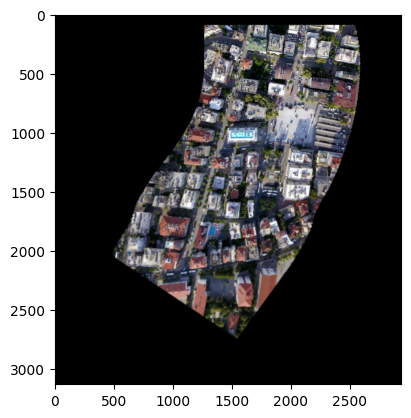

In [ ]:
#Import library
#import libraries
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt


def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2) #coordinates of a reference image
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2) #coordinates of second image

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)#calculate the transformation matrix

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min,-y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

#folfer containing images from drones, sorted by name
import glob

folder_path = '/content/F_output'  # Replace with the actual folder path

# Use the full path to the folder in glob.glob
path = sorted(glob.glob(folder_path + "/*.jpg"))

img_list = []
for img in path:
    n = cv2.imread(img)
    img_list.append(n)


"""Functions for stitching"""

#Use ORB detector to extract keypoints
orb = cv2.ORB_create(nfeatures=2000)
while True:
  img1=img_list.pop(0)
  img2=img_list.pop(0)
# Find the key points and descriptors with ORB
  keypoints1, descriptors1 = orb.detectAndCompute(img1, None)#descriptors are arrays of numbers that define the keypoints
  keypoints2, descriptors2 = orb.detectAndCompute(img2, None)


# Create a BFMatcher object to match descriptors
# It will find all of the matching keypoints on two images
  bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)#NORM_HAMMING specifies the distance as a measurement of similarity between two descriptors

# Find matching points
  matches = bf.knnMatch(descriptors1, descriptors2,k=2)

  all_matches = []
  for m, n in matches:
    all_matches.append(m)
# Finding the best matches
  good = []
  for m, n in matches:
    if m.distance < 0.6 * n.distance:#Threshold
        good.append(m)

# Set minimum match condition
  MIN_MATCH_COUNT = 5

  if len(good) > MIN_MATCH_COUNT:

    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    result = warpImages(img2, img1, M)

    img_list.insert(0,result)

    if len(img_list)==1:
      break
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite("/content/stitched.jpg", result)
plt.imshow(result)
plt.show()

Removing Background

In [ ]:
from rembg import remove
from PIL import Image

input_path = '/content/stitched.jpg'
output_path = '/content/bgremoved_stitched.png'

input = Image.open(input_path)
output = remove(input)
output.save(output_path)

**Defining the Function for Depth Estimation followed by 3D Model Generation**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

file_name = {}
file_name['name'] = ''
file_name['depth'] = "stitched_depth.png"
file_name['stl'] = "stitched_model.stl"

def process_clicked(st_img):
    print('Image Processing Started...')

    img = st_img
    # img = Image.open(path)

    if img.mode == 'RGBA':
        r, g, b, a = img.split()
        img = img.convert('RGB')

    # Generate low resolution image
    # low_res_depth = zoe.infer_pil(img)
    low_res_depth = dependencies['zoe'].infer_pil(img)
    low_res_scaled_depth = 2**16 - (low_res_depth - np.min(low_res_depth)) * 2**16 / (np.max(low_res_depth) - np.min(low_res_depth))

    low_res_depth_map_image = Image.fromarray((0.999 * low_res_scaled_depth).astype("uint16"))
    low_res_depth_map_image.save('zoe_depth_map_16bit_low.png')

    # Generate filters

    # store filters in lists
    im = np.asarray(img)

    tile_sizes = [[4,4], [8,8]]

    filters = []

    save_filter_images = True

    for tile_size in tile_sizes:

        num_x = tile_size[0]
        num_y = tile_size[1]

        M = im.shape[0]//num_x
        N = im.shape[1]//num_y

        filter_dict = {}
        filter_dict['right_filter'] = np.zeros((M, N))
        filter_dict['left_filter'] = np.zeros((M, N))
        filter_dict['top_filter'] = np.zeros((M, N))
        filter_dict['bottom_filter'] = np.zeros((M, N))
        filter_dict['top_right_filter'] = np.zeros((M, N))
        filter_dict['top_left_filter'] = np.zeros((M, N))
        filter_dict['bottom_right_filter'] = np.zeros((M, N))
        filter_dict['bottom_left_filter'] = np.zeros((M, N))
        filter_dict['filter'] = np.zeros((M, N))

        for i in range(M):
          for j in range(N):
              x_value = 0.998*np.cos((abs(M/2-i)/M)*np.pi)**2
              y_value = 0.998*np.cos((abs(N/2-j)/N)*np.pi)**2

              if j > N/2:
                  filter_dict['right_filter'][i,j] = x_value
              else:
                  filter_dict['right_filter'][i,j] = x_value * y_value

              if j < N/2:
                  filter_dict['left_filter'][i,j] = x_value
              else:
                  filter_dict['left_filter'][i,j] = x_value * y_value

              if i < M/2:
                  filter_dict['top_filter'][i,j] = y_value
              else:
                  filter_dict['top_filter'][i,j] = x_value * y_value

              if i > M/2:
                  filter_dict['bottom_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_filter'][i,j] = x_value * y_value

              if j > N/2 and i < M/2:
                  filter_dict['top_right_filter'][i,j] = 0.998
              elif j > N/2:
                  filter_dict['top_right_filter'][i,j] = x_value
              elif i < M/2:
                  filter_dict['top_right_filter'][i,j] = y_value
              else:
                  filter_dict['top_right_filter'][i,j] = x_value * y_value

              if j < N/2 and i < M/2:
                  filter_dict['top_left_filter'][i,j] = 0.998
              elif j < N/2:
                  filter_dict['top_left_filter'][i,j] = x_value
              elif i < M/2:
                  filter_dict['top_left_filter'][i,j] = y_value
              else:
                  filter_dict['top_left_filter'][i,j] = x_value * y_value

              if j > N/2 and i > M/2:
                  filter_dict['bottom_right_filter'][i,j] = 0.998
              elif j > N/2:
                  filter_dict['bottom_right_filter'][i,j] = x_value
              elif i > M/2:
                  filter_dict['bottom_right_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_right_filter'][i,j] = x_value * y_value

              if j < N/2 and i > M/2:
                  filter_dict['bottom_left_filter'][i,j] = 0.998
              elif j < N/2:
                  filter_dict['bottom_left_filter'][i,j] = x_value
              elif i > M/2:
                  filter_dict['bottom_left_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_left_filter'][i,j] = x_value * y_value

              filter_dict['filter'][i,j] = x_value * y_value

        filters.append(filter_dict)

        if save_filter_images:
            for filter in list(filter_dict.keys()):
                filter_image = Image.fromarray((filter_dict[filter]*2**16).astype("uint16"))
                filter_image.save(f'mask_{filter}_{num_x}_{num_y}.png')


    # filters second section
    compiled_tiles_list = []

    for i in range(len(filters)):

        num_x = tile_sizes[i][0]
        num_y = tile_sizes[i][1]

        M = im.shape[0]//num_x
        N = im.shape[1]//num_y

        compiled_tiles = np.zeros((im.shape[0], im.shape[1]))

        x_coords = list(range(0,im.shape[0],im.shape[0]//num_x))[:num_x]
        y_coords = list(range(0,im.shape[1],im.shape[1]//num_y))[:num_y]

        x_coords_between = list(range((im.shape[0]//num_x)//2, im.shape[0], im.shape[0]//num_x))[:num_x-1]
        y_coords_between = list(range((im.shape[1]//num_y)//2,im.shape[1],im.shape[1]//num_y))[:num_y-1]

        x_coords_all = x_coords + x_coords_between
        y_coords_all = y_coords + y_coords_between

        for x in x_coords_all:
            for y in y_coords_all:

                # depth = zoe.infer_pil(Image.fromarray(np.uint8(im[x:x+M,y:y+N])))
                depth = dependencies['zoe'].infer_pil(Image.fromarray(np.uint8(im[x:x+M,y:y+N])))


                scaled_depth = 2**16 - (depth - np.min(depth)) * 2**16 / (np.max(depth) - np.min(depth))

                if y == min(y_coords_all) and x == min(x_coords_all):
                    selected_filter = filters[i]['top_left_filter']
                elif y == min(y_coords_all) and x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_left_filter']
                elif y == max(y_coords_all) and x == min(x_coords_all):
                    selected_filter = filters[i]['top_right_filter']
                elif y == max(y_coords_all) and x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_right_filter']
                elif y == min(y_coords_all):
                    selected_filter = filters[i]['left_filter']
                elif y == max(y_coords_all):
                    selected_filter = filters[i]['right_filter']
                elif x == min(x_coords_all):
                    selected_filter = filters[i]['top_filter']
                elif x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_filter']
                else:
                    selected_filter = filters[i]['filter']

                compiled_tiles[x:x+M, y:y+N] += selected_filter * (np.mean(low_res_scaled_depth[x:x+M, y:y+N]) + np.std(low_res_scaled_depth[x:x+M, y:y+N]) * ((scaled_depth - np.mean(scaled_depth)) /  np.std(scaled_depth)))

        compiled_tiles[compiled_tiles < 0] = 0
        compiled_tiles_list.append(compiled_tiles)

        tiled_depth_map = Image.fromarray((2**16 * 0.999 * compiled_tiles / np.max(compiled_tiles)).astype("uint16"))
        tiled_depth_map.save(f'tiled_depth_{i}.png')

    # combine depth maps
    from scipy.ndimage import gaussian_filter

    grey_im = np.mean(im,axis=2)

    tiles_blur = gaussian_filter(grey_im, sigma=20)
    tiles_difference = tiles_blur - grey_im

    tiles_difference = tiles_difference / np.max(tiles_difference)

    tiles_difference = gaussian_filter(tiles_difference, sigma=40)

    tiles_difference *= 5

    tiles_difference = np.clip(tiles_difference, 0, 0.999)

    mask_image = Image.fromarray((tiles_difference*2**16).astype("uint16"))
    mask_image.save('mask_image.png')

    combined_result = (tiles_difference * compiled_tiles_list[1] + (1-tiles_difference) * ((compiled_tiles_list[0] + low_res_scaled_depth)/2))/(2)

    combined_image = Image.fromarray((2**16 * 0.999* combined_result / np.max(combined_result)).astype("uint16"))
    # combined_image.save('combined_image.png')
    combined_image.save(file_name['depth'])

    # display output images

    print('Original low resolution result')
    plt.imshow(low_res_scaled_depth, 'magma')
    plt.axis("off")
    plt.show()

    print('\nNew high resolution result')
    plt.imshow(combined_result, 'magma')
    plt.axis("off")
    plt.show()

    print("Image Processing done. Depth was successfully Estimated.")
    print("Started processing mesh...")

    # !pip install numpy-stl
    # from stl import mesh
    # import cv2

    # im = cv2.imread('combined_image.png', cv2.IMREAD_UNCHANGED)
    im = cv2.imread(file_name['depth'], cv2.IMREAD_UNCHANGED)

    im_array = np.array(im) #.transpose((1, 0, 2))
    im_array = np.rot90(im_array, -1, (0,1))

    mesh_size = [im_array.shape[0],im_array.shape[1]]

    mesh_max = np.max(im_array)

    if len(im_array.shape) == 3:
        scaled_mesh = mesh_size[0] * float(0.2) * im_array[:,:,0] / mesh_max
    else:
        scaled_mesh = mesh_size[0] * float(0.2) * im_array / mesh_max
    # rand_mesh = np.random.rand(mesh_size[0],mesh_size[1])

    mesh_shape = mesh.Mesh(np.zeros((mesh_size[0] - 1) * (mesh_size[1] - 1) * 2, dtype=mesh.Mesh.dtype))

    for i in range(0, mesh_size[0]-1):
        for j in range(0, mesh_size[1]-1):
            mesh_num = i * (mesh_size[1]-1) + j

            mesh_shape.vectors[2 * mesh_num][2] = [i, j, scaled_mesh[i,j]]
            mesh_shape.vectors[2 * mesh_num][1] = [i, j+1, scaled_mesh[i,j+1]]
            mesh_shape.vectors[2 * mesh_num][0] = [i+1, j, scaled_mesh[i+1,j]]

            mesh_shape.vectors[2 * mesh_num + 1][0] = [i+1, j+1, scaled_mesh[i+1,j+1]]
            mesh_shape.vectors[2 * mesh_num + 1][1] = [i, j+1, scaled_mesh[i,j+1]]
            mesh_shape.vectors[2 * mesh_num + 1][2] = [i+1, j, scaled_mesh[i+1,j]]

    mesh_shape.save(file_name['stl'])
    files.download(file_name['stl'])

    print("Image converted to Mesh Successfully.")

**Function Call**

> Passing the stitched images into the function



In [ ]:
stitched_image_mesh_data  = process_clicked(result)